In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov


Populating the interactive namespace from numpy and matplotlib


In [2]:
df=sqlContext.read.csv('SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_D' in c]
tickers=[a[:-2] for a in col]
tickers[:10],len(tickers)

(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA', 'WM', 'SPG'], 481)

In [5]:
def make_array(row):
    array=np.array([row[c] for c in col],dtype=np.float64)
    return np.nan_to_num(array)
Rows=df.select(col).rdd.map(make_array)

Rows.first()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00830103,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [6]:
OUT=computeCov(Rows)
OUT.keys()

shape of E= (481,) shape of NE= (481,)


['E', 'Cov', 'NO', 'NE', 'O', 'Var', 'Mean']

[ 0.21541202  0.25336645  0.27722061  0.29994765  0.31293977]


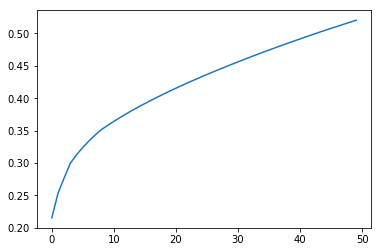

In [7]:
from numpy import linalg as LA
eigval,eigvec=LA.eigh(OUT['Cov'])
eigval=eigval[-1::-1] # reverse order
eigvec=eigvec[:,-1::-1]
cum=cumsum(eigval)
cum=cum/cum[-1]
print cum[:5]
plot(cum[:50])

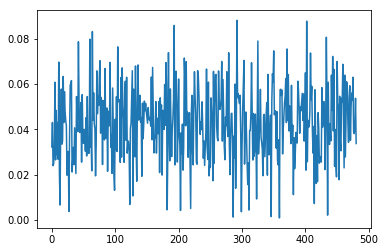

In [8]:
eigen_vecs=eigvec.transpose
plot(eigvec[:,0])

In [23]:
import pickle
D=pickle.load(open('Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
tickers=D['Tickers']
TickerInfo.head()

,Ticker,Name,Sector,SECTOR_ID
0,MMM,3M|3M Company,Industrials,INDS
1,ABT,Abbott Laboratories,Health Care,HC
2,ABBV,AbbVie Inc.,Health Care,HC
3,ACN,Accenture plc,Information Technology,IT
4,ATVI,Activision Blizzard,Information Technology,IT


In [204]:
TickerInfo[TickerInfo['SECTOR_ID']=='EN']

,Ticker,Name,Sector,SECTOR_ID
41,APC,Anadarko Petroleum|Anadarko Petroleum Corp,Energy,EN
45,APA,Apache Corporation,Energy,EN
60,BHI,Baker Hughes Inc,Energy,EN
83,COG,Cabot Oil & Gas,Energy,EN
101,CHK,Chesapeake Energy,Energy,EN
102,CVX,Chevron Corp.,Energy,EN
107,XEC,Cimarex Energy,Energy,EN
124,CXO,Concho Resources,Energy,EN
125,COP,ConocoPhillips,Energy,EN
145,DVN,Devon Energy,Energy,EN


In [205]:
NN=TickerInfo[['Ticker','SECTOR_ID']]
Ticker2Sector={ a[1]:a[2] for a in NN.to_records()}
Ticker2Sector.items()[:3]

[('AGN', 'HC'), ('EOG', 'EN'), ('CPB', 'CS')]

In [206]:
sectors=[]
missing=[]
good_tickers=[]
for a in tickers:
    if a in Ticker2Sector:
        good_tickers.append(a)
        b=Ticker2Sector[a] 
    else:
        b=a
        missing.append(a)
    sectors.append(b)

print 'tickers=',len(tickers),'good tickers=',len(good_tickers),'missing=',len(missing)



tickers= 481 good tickers= 392 missing= 89


In [207]:
len(sectors),len(tickers)

(481, 481)

In [208]:
# Generate the scatter plot of the stocks on a pair of eigen-vectors defined by i0,i1
i0=0;i1=3
fig, ax = plt.subplots(figsize=(20,20))  # In order that the stock ticker names are readable we make the plot very large
plt.xlim([np.amin(eigvec[:,i0]),np.amax(eigvec[:,i0])])
plt.ylim([np.amin(eigvec[:,i1]),np.amax(eigvec[:,i1])])
plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=20)
for i in range(len(tickers)):
    #ax.annotate(tickers[i], (eigvec[i0,i],eigvec[i1,i]),fontsize=10)
    ax.annotate(sectors[i], (eigvec[i,i0],eigvec[i,i1]),fontsize=10)
# This very large plot is hard to view and manipulate inside the notebook. We therefor export it into a pdf file
fig.savefig('scatter2.'+str(i0)+str(i1)+'.pdf', format='PDF')
# After exporting, we clear the figure so that the plot does not appear in the notebook.
fig.clear()
!open *.pdf

In [18]:
!ls -l *.pdf

-rw-r--r--  1 yoavfreund  staff  16043 Jun  5 15:14 scatter2.01.pdf
-rw-r--r--@ 1 yoavfreund  staff  18514 Jun  5 15:13 scatter2.12.pdf


In [63]:
!open *.pdf

In [17]:
!rm *.pdf

### Performing K-NN on sectors.

In [27]:
eigvec.shape

(481, 481)

In [65]:
Tick_rep={}
for i in range(len(tickers)):
    Tick_rep[tickers[i]]=eigvec[i,:]

In [66]:
len(sectors)

481

In [209]:
d=20
k=5
T='HAL'
#def find_closest(T):
v=np.zeros([d,1])
print v.shape
v=np.array([Tick_rep[T][:d]])
print v.shape
g=eigvec[:,:d]
v.shape, g.shape
D=g-v
shape(D)

(20, 1)
(1, 20)


(481, 20)

In [210]:
A=sum(D**2,axis=1)
A.shape

(481,)

In [211]:
A[:5]

array([ 0.09860949,  0.04754253,  0.10654787,  0.09634303,  0.08711626])

In [212]:
paired=zip(tickers,sectors,A)

In [213]:
paired[:3]

[('AGN', 'HC', 0.098609486029386059),
 ('EOG', 'EN', 0.047542533220900622),
 ('WLP', 'WLP', 0.10654787115402582)]

In [214]:
sorted(paired,key=lambda x:x[2])[:10]

[('HAL', 'EN', 0.0),
 ('SLB', 'EN', 0.010296837057985155),
 ('APA', 'EN', 0.019388603982910216),
 ('HP', 'EN', 0.019907688279716545),
 ('DO', 'DO', 0.026788775308021994),
 ('RDC', 'RDC', 0.027206769982679565),
 ('BHI', 'EN', 0.0274460557545377),
 ('NBL', 'EN', 0.028030555345745726),
 ('ESV', 'ESV', 0.030369777890182553),
 ('NE', 'NE', 0.030519483519936552)]

In [189]:
print Tick_rep['MSFT'][:10]
print Tick_rep['CMI'][:10]

[ 0.0505805  -0.06034842 -0.02390029  0.05762165 -0.00588333  0.03110737
  0.00010003 -0.01988794  0.00993705  0.01987076]
[ 0.06156575  0.02898278  0.01298336  0.00618943 -0.00719973 -0.05281253
 -0.07426094 -0.00772463 -0.00891115 -0.01868773]


In [147]:
first_eig=zip(tickers,sectors,g.transpose())

In [148]:
L=sorted(first_eig,key=lambda x:x[2])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [74]:
L[:10]

[('CTSH', 'IT', array([-0.22578818])),
 ('MCK', 'HC', array([-0.21613648])),
 ('KO', 'CS', array([-0.19417533])),
 ('HSY', 'CS', array([-0.15939419])),
 ('SRCL', 'INDS', array([-0.15290304])),
 ('EXPE', 'CD', array([-0.13939156])),
 ('CLX', 'CS', array([-0.12446722])),
 ('PG', 'CS', array([-0.122607])),
 ('NFLX', 'IT', array([-0.121737])),
 ('RHT', 'IT', array([-0.11160443]))]

In [75]:
L[-10:]

[('WU', 'IT', array([ 0.11240168])),
 ('DE', 'INDS', array([ 0.11428248])),
 ('VMC', 'MAT', array([ 0.12049265])),
 ('PSA', 'RE', array([ 0.13544218])),
 ('SEE', 'MAT', array([ 0.14295425])),
 ('NRG', 'UTIL', array([ 0.15548348])),
 ('AES', 'UTIL', array([ 0.16581563])),
 ('UNP', 'INDS', array([ 0.17015442])),
 ('VTR', 'RE', array([ 0.18742418])),
 ('VNO', 'RE', array([ 0.21565865]))]